# Image Recognition & Transfer Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

Notebook for an example end-to-end Deep Learning project:
- Creating a new Dataset by scraping images from Google Images
- Building an efficient datapipeline for images with tf.data (with data augmentation)
- Training using Transfer Learning (by gradually unfreezing more and more layers) 

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    %load_ext tensorboard
except Exception:
    pass

import tensorflow as tf
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
import os
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


# Part 1: Create a Dataset (Web Scraping)

We will create a Dataset with images from 3 different categories "smartphone", "laptop", "blender" using images from Google Images. To download the images in an automated fashion, we will use the python tool <code>google_images_download</code>. 

To download more than 100 images with <code>google_images_download</code> you need to chrome installed on your system, and download chromedriver.
As we can't do this on Colab, we will do it on our local machine:
1. Install Chrome
2. Download chromedriver.exe from https://sites.google.com/a/chromium.org/chromedriver/downloads
3. <code>> pip install google_images_download</code>
4. Download images using keywords "smartphone", "laptop", "blender"
```
googleimagesdownload -k "smartphone" -l 200 --chromedriver C:\Windows\chromedriver.exe
googleimagesdownload -k "laptop" -l 200 --chromedriver C:\Windows\chromedriver.exe
googleimagesdownload -k "blender" -l 200 --chromedriver C:\Windows\chromedriver.exe
```
5. Upload the images to a cloud storage (e.g Google Drive, Google Cloud Storage, AWS S3)
6. Download the images to your Colab Instance 


### Load Data


In [0]:
import os
URL = 'https://storage.googleapis.com/dl-workshop/datasets/laptop_smartphone_blender.zip'

path_to_zip = tf.keras.utils.get_file('laptop_smartphone_blender.zip', origin=URL, extract=True)
dataset_path = os.path.join(os.path.dirname(path_to_zip), 'laptop_smartphone_blender')

In [0]:
import pathlib
import os
import random

data_root = pathlib.Path(dataset_path)

class_names = sorted([e.name for e in (data_root).iterdir() if e.is_dir()])
class_names_to_label = {name: label for label, name in enumerate(class_names)}
label_to_class_names = {label: name for label, name in enumerate(class_names)}

label_to_class_names

{0: 'blender', 1: 'laptop', 2: 'smartphone'}

In [0]:
def remove_invalid_images(image_paths):
    valid_image_paths = []

    for path in image_paths:
        try:
            image = tf.io.read_file(str(path))
            image = tf.image.decode_jpeg(image, channels=3)
            valid_image_paths.append(path)
        except:
            # print(f'invalid image file found: {path}')
            pass

    print(f'\n{len(image_paths) - len(valid_image_paths)} out of {len(image_paths)} files will be ignored')
    
    return valid_image_paths

In [0]:
supported_filetypes = {'png', 'jpg', 'jpeg'}

all_image_paths = []

for f_type in supported_filetypes:
    all_image_paths += list(data_root.glob(f'*/*.{f_type}'))

random.seed(0)
random.shuffle(all_image_paths)

all_image_paths = remove_invalid_images(all_image_paths)

all_image_labels = []

for i, path in enumerate(all_image_paths):
    all_image_labels.append(class_names_to_label[path.parent.name])
    all_image_paths[i] = str(all_image_paths[i])


43 out of 594 files will be ignored


In [0]:
nr_train_images = int(0.7*len(all_image_paths))

train_image_paths = all_image_paths[:nr_train_images]
test_image_paths = all_image_paths[nr_train_images:]

train_image_labels = all_image_labels[:nr_train_images]
test_image_labels = all_image_labels[nr_train_images:]

len(test_image_labels)

166

# Part 2: Create a Data Pipeline (with Data Augmentation)


https://www.tensorflow.org/guide/data <br>
For performance reasons, we encourage you to use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the tf.py_function() operation in a Dataset.map() transformation.

In [0]:
import scipy.ndimage as ndimage
import numpy as np


def random_rotate_image(image):
    image =  ndimage.rotate(image, np.random.uniform(-30,30), reshape=False)
    return image

def tf_random_rotate_image(image):
    img_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(img_shape)
    return image

def random_crop(image, random=True):
    if random:
        shape = tf.shape(image)
        min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
        image = tf.image.random_crop(image, [min_dim, min_dim, 3])
    else:
        image = tf.image.central_crop(image, 0.5)

    return image

def random_color(image):
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.6, 1.6)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    
    return image

In [0]:
from functools import partial

IMG_SHAPE = (64, 64)

def random_augs(image):
    choice1 = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    image = tf.cond(choice1 > 0.7, lambda: image, lambda: random_crop(image))

    choice2 = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    image = tf.cond(choice2 > 0.7, lambda: image, lambda: random_color(image))

    choice3 = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    image = tf.cond(choice3 > 0.7, lambda: image, lambda: tf_random_rotate_image(image))

    return image


def augmentations(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return random_augs(image)


def load_and_preprocess_image(image_path, label, img_shape, augmentation):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = keras.applications.resnet_v2.preprocess_input(tf.cast(image, tf.float32))

    if augmentation:
        image = augmentations(image)
        image = tf.clip_by_value(image, -1, 1)

    image = tf.image.resize(image, img_shape)
    label = tf.cast(label, tf.float32)    

    return image, label


def create_dataset(file_paths, labels, epochs=1, batch_size=64, buffer_size=10000, train=True, augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(partial(load_and_preprocess_image, img_shape=IMG_SHAPE, augmentation=augmentation), num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

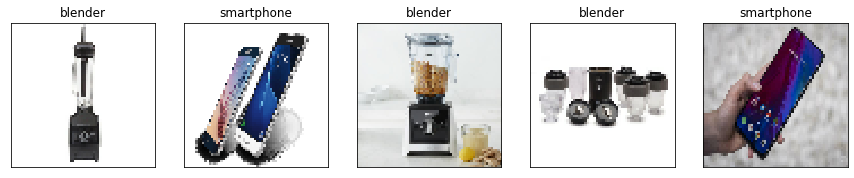

In [0]:
import matplotlib.pyplot as plt

ds = create_dataset(train_image_paths, train_image_labels, batch_size=5, train=False, augmentation=False)

for batch, labels in ds.take(1):
    fig, ax = plt.subplots(1, len(batch), figsize=(15,20))
    for i, (img, label) in enumerate(zip(batch, labels)):
        fig.axes[i].imshow((img+1)/2)
        fig.axes[i].set_title(label_to_class_names[labels[i].numpy()])
        fig.axes[i].set_xticks([])
        fig.axes[i].set_yticks([])

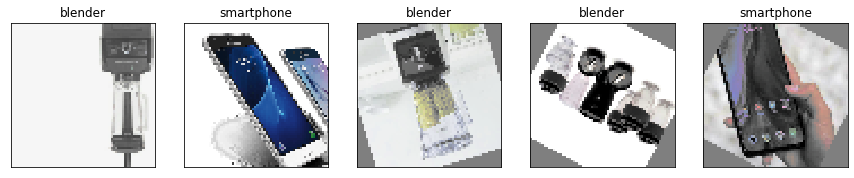

In [0]:
ds = create_dataset(train_image_paths, train_image_labels, batch_size=5, train=False, augmentation=True)

for batch, labels in ds.take(1):
    fig, ax = plt.subplots(1, len(batch), figsize=(15,20))
    for i, (img, label) in enumerate(zip(batch, labels)):
        fig.axes[i].imshow((img+1)/2)
        fig.axes[i].set_title(label_to_class_names[labels[i].numpy()])
        fig.axes[i].set_xticks([])
        fig.axes[i].set_yticks([])

# Part 3: Modelling

## Baseline Model (LeNet-5)

In [0]:
from tensorflow.keras import layers, models

def create_baseline_model(nr_classes, input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(nr_classes, activation='softmax')
    ])


model = create_baseline_model(nr_classes=len(class_names), input_shape=IMG_SHAPE + (3,))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)               

In [0]:
model = create_baseline_model(nr_classes=len(class_names), input_shape=IMG_SHAPE + (3,))
model.summary()

nr_epochs = 30
batch_size = 32

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=nr_epochs, batch_size=batch_size, train=True, augmentation=False)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=nr_epochs, batch_size=batch_size, train=False, augmentation=False)

steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(test_image_paths) // batch_size

model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs = nr_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

Train for 12 steps, validate for 5 steps
Epoch 1/30
12/12 [==============================] - 10s 850ms/step - loss: 0.9299 - accuracy: 0.5130 - val_loss: 0.7423 - val_accuracy: 0.7125
Epoch 2/30
12/12 [==============================] - 3s 284ms/step - loss: 0.7374 - accuracy: 0.7214 - val_loss: 0.6500 - val_accuracy: 0.7937
Epoch 3/30
12/12 [==============================] - 3s 283ms/step - loss: 0.5810 - accuracy: 0.8203 - val_loss: 0.5769 - val_accuracy: 0.7688
Epoch 4/30
12/12 [==============================] - 3s 287ms/step - loss: 0.4759 - accuracy: 0.7995 - val_loss: 0.6246 - val_accuracy: 0.7437
Epoch 5/30
12/12 [==============================] - 3s 280ms/step - loss: 0.3936 - accuracy: 0.8438 - val_loss: 0.4873 - val_accuracy: 0.7937
Epoch 6/30
12/12 [==============================] - 4s 297ms/step - loss: 0.2917 - accuracy: 0.9036 - val_loss: 0.4378 - val_accuracy: 0.8000
Epoch 7/30
12/12 [==============================] - 4s 301ms/step - loss: 0.2372 - accuracy: 0.9219 - val_

## Using Transfer Learning (ResNet-50)

In [0]:
def create_resnet50_model(nr_classes, learning_rate=3e-4, dropout=0):
    base_model = keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
    
    for layer in base_model.layers:
        if layer.__class__.__name__ != "BatchNormalization":
            layer.trainable = False
    
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    mx = keras.layers.GlobalMaxPooling2D()(base_model.output)
    out = tf.keras.layers.Concatenate()([avg, mx])
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0)(out)
    out = keras.layers.Dense(512, activation="relu")(out)
    out = keras.layers.BatchNormalization()(out)
    out = keras.layers.Dropout(0)(out)
    out = keras.layers.Dense(nr_classes, activation="softmax")(out)
    
    model = keras.models.Model(inputs=base_model.input, outputs=out)
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


def unfreeze(model, nr_unfreezed_layers=None, lr=0.0001):
    if nr_unfreezed_layers == None:
        nr_freezed_layers = 0
    else:
        nr_freezed_layers = len(model.layers) - nr_unfreezed_layers

    model.trainable = True
    for i in range(len(model.layers)):
        if i < nr_freezed_layers:
            model.layers[i].trainable = False
        else:
            model.layers[i].trainable = True
            if nr_unfreezed_layers:
                print(f'Unfreezed Layer {i}: {model.layers[i]}')

    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Training without augmentation

In [0]:
BATCH_SIZE = 32
steps_per_epoch = len(train_image_paths) // BATCH_SIZE
validation_steps = len(test_image_paths) // BATCH_SIZE

### Step 1: Training Freezed Model

In [0]:
model = create_resnet50_model(len(class_names), learning_rate=2e-4)

nr_epochs = 15

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=True)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=False)

history = model.fit(train_ds,
                    epochs = nr_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

model.save_weights('./step-1/checkpoint')

Train for 12 steps, validate for 5 steps
Epoch 1/15
12/12 [==============================] - 22s 2s/step - loss: 1.2169 - accuracy: 0.5182 - val_loss: 1.2112 - val_accuracy: 0.5688
Epoch 2/15
12/12 [==============================] - 5s 399ms/step - loss: 0.5607 - accuracy: 0.7943 - val_loss: 0.9399 - val_accuracy: 0.6750
Epoch 3/15
12/12 [==============================] - 5s 386ms/step - loss: 0.3766 - accuracy: 0.8464 - val_loss: 0.9504 - val_accuracy: 0.6625
Epoch 4/15
12/12 [==============================] - 5s 390ms/step - loss: 0.3246 - accuracy: 0.8802 - val_loss: 0.8502 - val_accuracy: 0.7250
Epoch 5/15
12/12 [==============================] - 5s 386ms/step - loss: 0.2438 - accuracy: 0.9167 - val_loss: 0.7973 - val_accuracy: 0.7063
Epoch 6/15
12/12 [==============================] - 5s 388ms/step - loss: 0.1848 - accuracy: 0.9323 - val_loss: 0.7524 - val_accuracy: 0.7188
Epoch 7/15
12/12 [==============================] - 5s 386ms/step - loss: 0.1925 - accuracy: 0.9245 - val_los

### Step 2: Unfreeze last 30 Layers

In [0]:
# Create a new model instance
model = create_resnet50_model(len(class_names))

# Restore the weights
model.load_weights('./step-1/checkpoint')

model = unfreeze(model, nr_unfreezed_layers=30, lr=0.0001)

nr_epochs = 25

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=True)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=False)

history = model.fit(train_ds,
                    epochs = nr_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

model.save_weights('./step-2/checkpoint')

Unfreezed Layer 169: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5c01bd36a0>
Unfreezed Layer 170: <tensorflow.python.keras.layers.core.Activation object at 0x7f5c01bd3f60>
Unfreezed Layer 171: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f5c01bad400>
Unfreezed Layer 172: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5c01bdd080>
Unfreezed Layer 173: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5c01b47860>
Unfreezed Layer 174: <tensorflow.python.keras.layers.core.Activation object at 0x7f5c01b65160>
Unfreezed Layer 175: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5c01b2ec18>
Unfreezed Layer 176: <tensorflow.python.keras.layers.merge.Add object at 0x7f5c01add400>
Unfreezed Layer 177: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5c01add470>
Unfreezed Layer 178: <tensorflow.python.keras.layers.core.Activation object at

### Step 3: Unfreeze last 50 Layers

In [0]:
# Create a new model instance
model = create_resnet50_model(len(class_names))

# Restore the weights
model.load_weights('./step-2/checkpoint')

model = unfreeze(model, nr_unfreezed_layers=50, lr=0.00004)

nr_epochs = 30

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=True)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=nr_epochs, batch_size=BATCH_SIZE, train=False)

history = model.fit(train_ds,
                    epochs = nr_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

model.save_weights('./step-3/checkpoint')

Unfreezed Layer 149: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5bf51a5f28>
Unfreezed Layer 150: <tensorflow.python.keras.layers.core.Activation object at 0x7f5bf5138978>
Unfreezed Layer 151: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5bf52aa940>
Unfreezed Layer 152: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bf5172f98>
Unfreezed Layer 153: <tensorflow.python.keras.layers.merge.Add object at 0x7f5bf5128c18>
Unfreezed Layer 154: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5bf5128d30>
Unfreezed Layer 155: <tensorflow.python.keras.layers.core.Activation object at 0x7f5bf50b9f98>
Unfreezed Layer 156: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5bf50aef28>
Unfreezed Layer 157: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5bf5040fd0>
Unfreezed Layer 158: <tensorflow.python.keras.layers.core.Activation object at 0x7f5b

### Step 4: Unfreeze all Layers

In [0]:
# Create a new model instance
model = create_resnet50_model(len(class_names))

# Restore the weights
model.load_weights('./step-3/checkpoint')

model = unfreeze(model, lr=0.00003)

nr_epochs = 150
batch_size = 32

train_ds = create_dataset(train_image_paths, train_image_labels, epochs=nr_epochs, batch_size=batch_size, train=True)
test_ds = create_dataset(test_image_paths, test_image_labels, epochs=nr_epochs, batch_size=batch_size, train=False)

history = model.fit(train_ds,
                    epochs = nr_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = test_ds, 
                    validation_steps = validation_steps,
                    callbacks = [])

model.save_weights('./step-4/checkpoint')

Unfreezed Layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5bffff1048>
Unfreezed Layer 1: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f5c06a0d518>
Unfreezed Layer 2: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5befaa3a20>
Unfreezed Layer 3: <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f5bffff1f98>
Unfreezed Layer 4: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5bee23f588>
Unfreezed Layer 5: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5c0e168860>
Unfreezed Layer 6: <tensorflow.python.keras.layers.core.Activation object at 0x7f5bffff8588>
Unfreezed Layer 7: <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5c00068518>
Unfreezed Layer 8: <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f5c00070710>
Unfreezed Layer 9: <tensorflow.python.keras.layers.core.Activation object at 0x7f5c